In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time 
import gpytorch
from gpytorch.functions import pivoted_cholesky

from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
import torch
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Set device and global dtype
device = "cuda:0"
global_dtype = torch.float32

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Add project source path
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)

# Import custom modules
from gps import CholeskyGaussianProcess, IterativeGaussianProcess
from util import train, eval, plot_gpr_results, fetch_uci_dataset, memory_dump
from plotting import plot_gp_simple, plot_gp_sample, plot_gp_simple_regions

# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2
train_x, train_y, test_x, test_y = fetch_uci_dataset('bike',r"C:\Users\fredw\chris\Research\softki\data\uci_datasets\uci_datasets\elevators\data.csv",train_frac=1/10,val_frac=0)
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
print(train_x.shape)

SIZE (16599, 19)
Dataset loaded
torch.Size([1659, 17])


In [3]:
import torch
import matplotlib.pyplot as plt
from line_profiler import LineProfiler
from preconditioners import build_cholesky,_pivoted_cholesky

def train2(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)

    # optimizer = torch.optim.Adam([
    #     {'params': model.kernel.parameters()}, 
    #     {'params': [model.noise.u]}  # Use raw_value instead of noise()
    # ], lr=lr)
    # runtime_log, mll_loss_log, test_rmse_log = [], [], []
    # for i in tqdm(range(training_iterations)):
    #     start_time = time.time()
    #     optimizer.zero_grad()
        
    #     model.fit(train_x, train_y)
    #     loss = model.compute_mll(train_y)
    #     loss.backward()
    #     optimizer.step()
    #     # scheduler.step()  # Update the learning rate

    #     # print(loss)
    #     mean,covar = model.predict(test_x)
    #     total_time = time.time() - start_time
    #     runtime_log.append(total_time)
    #     mll_loss_log.append(-loss.item())
        
    #     test_rmse = (torch.mean(torch.abs(mean.detach().cpu() - test_y))).item()
    #     test_rmse_log.append(test_rmse)
    #     if (i + 1) % 20 == 0:
    #         print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    # return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar


def run_igp_training():
    # Set up the base and scaled kernel for the IGP
    base_kernel_igp = MaternKernel(ard_num_dims=train_x.shape[-1], 
                                   lengthscale_prior=GammaPrior(-3.0, 3.0), 
                                   nu=1.5)
    kernel_igp = ScaleKernel(base_kernel_igp, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
    
    # Initialize the Iterative Gaussian Process model with the desired parameters
    igp_model = IterativeGaussianProcess(
        kernel=kernel_igp, 
        noise=0.4, 
        dtype=global_dtype, 
        device=device,
        cg_tol=1e-3, 
        cg_max_iter=100, 
        warm_start=True, 
        num_probes=16,
        precon_type="piv_chol", 
        trace_backend="Hutch",
        verbose=False, 
        track_iterations=True, 
        pred_lanczos_rank=train_x.shape[0],
        compute_covariance=False
    )
    
    training_iterations = 1
    lr = 0.01

    print("Training Iterative Gaussian Process (IGP)")
    # Train the IGP model and capture relevant outputs2
    results = train2(igp_model, train_x, train_y, test_x, test_y, training_iterations, lr)
    return results

# Set up the line profiler
lp = LineProfiler()
from mbcg import take_cg_step
# from preconditioners import _pivoted_cholesky
# Add the main training function and key IGP class methods you want to profile.
# Here we add the train function, and as an example, the forward method of IterativeGaussianProcess.
lp.add_function(train2)
lp.add_function(take_cg_step)
lp.add_function(build_cholesky)
lp.add_function(_pivoted_cholesky)

lp.add_function(IterativeGaussianProcess.forward)
lp.add_function(IterativeGaussianProcess.fit)
lp.add_function(IterativeGaussianProcess.get_preconditioner)

# If there are other important methods (for example, an 'optimize' method), add them similarly:
# lp.add_function(IterativeGaussianProcess.optimize)

# Wrap the IGP training run with the profiler and execute it.
lp_wrapper = lp(run_igp_training)
results = lp_wrapper()

# Print out the profiling statistics.
lp.print_stats()

Training Iterative Gaussian Process (IGP)
Timer unit: 1e-07 s

Total time: 0.408727 s
File: C:\Users\fredw\AppData\Local\Temp\ipykernel_13764\1127625354.py
Function: train2 at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def train2(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
     7         1    3216024.0    3e+06     78.7      model.fit(train_x, train_y)
     8         1     871242.0 871242.0     21.3      model.fit(train_x, train_y)
     9                                           
    10                                               # optimizer = torch.optim.Adam([
    11                                               #     {'params': model.kernel.parameters()}, 
    12                                               #     {'params': [model.noise.u]}  # Use raw_value instead of noise()
    13                                               # ], lr=lr)
    14                           

In [2]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming the following GP classes and kernels are defined elsewhere:
# MaternKernel, GammaPrior, ScaleKernel, CholeskyGaussianProcess, IterativeGaussianProcess

def run_cholesky_gp(train_x, train_y, test_x, test_y, device, global_dtype):
    base_kernel = MaternKernel(
        ard_num_dims=train_x.shape[-1],
        lengthscale_prior=GammaPrior(3.0, 6.0),
        nu=1.5,
        compute_covariance=False
    )
    kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
    gpr = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)
    
    start_fit = time.time()
    gpr.fit(train_x, train_y)
    chol_fit_time = time.time() - start_fit

    start_pred = time.time()
    chol_mean, GP_covariance = gpr.predict(test_x)
    chol_pred_time = time.time() - start_pred

    chol_rmse = torch.mean(torch.abs(chol_mean.detach().cpu() - test_y)).item()
    chol_total_time = chol_fit_time + chol_pred_time

    return chol_total_time, chol_fit_time, chol_pred_time, chol_rmse

def run_iterative_gp(train_x, train_y, test_x, test_y, device, global_dtype):
    base_kernel = MaternKernel(
        ard_num_dims=train_x.shape[-1],
        lengthscale_prior=GammaPrior(3.0, 6.0),
        nu=1.5
    )
    kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
    
    igp = IterativeGaussianProcess(
        kernel=kernel,
        noise=0.4,
        dtype=global_dtype,
        device=device,
        cg_tol=1e-3,
        cg_max_iter=20,
        warm_start=False,
        num_probes=16,
        precon_type="piv_chol",
        trace_backend="Hutch",
        verbose=False,
        track_iterations=True,
        pred_lanczos_rank=train_x.shape[0],
        compute_covariance=False
    )
    
    start_fit = time.time()
    igp.fit(train_x, train_y)
    iter_fit_time = time.time() - start_fit

    start_pred = time.time()
    mean, covar = igp.predict(test_x)
    iter_pred_time = time.time() - start_pred
    
    iter_total_time = iter_fit_time + iter_pred_time
    iter_rmse = torch.mean(torch.abs(mean.detach().cpu() - test_y)).item()

    del igp, kernel, base_kernel
    torch.cuda.empty_cache()
    
    return iter_total_time, iter_fit_time, iter_pred_time, iter_rmse

# Number of runs to average over
num_runs = 1

chol_metrics = []
iter_metrics = []

for _ in range(num_runs):
    chol_metrics.append(run_cholesky_gp(train_x, train_y, test_x, test_y, device, global_dtype))
    iter_metrics.append(run_iterative_gp(train_x, train_y, test_x, test_y, device, global_dtype))

# Convert to numpy arrays for averaging
chol_metrics = np.array(chol_metrics)
iter_metrics = np.array(iter_metrics)

# Each metric: [total_time, fit_time, pred_time, rmse]
chol_total_avg, chol_fit_avg, chol_pred_avg, chol_rmse_avg = np.mean(chol_metrics, axis=0)
iter_total_avg, iter_fit_avg, iter_pred_avg, iter_rmse_avg = np.mean(iter_metrics, axis=0)

fit_speedup = ((chol_fit_avg - iter_fit_avg) / chol_fit_avg) * 100
pred_speedup = ((chol_pred_avg - iter_pred_avg) / chol_pred_avg) * 100
total_speedup = ((chol_total_avg - iter_total_avg) / chol_total_avg) * 100

fit_factor = chol_fit_avg / iter_fit_avg if iter_fit_avg != 0 else float('inf')
pred_factor = chol_pred_avg / iter_pred_avg if iter_pred_avg != 0 else float('inf')
total_factor = chol_total_avg / iter_total_avg if iter_total_avg != 0 else float('inf')

RED = "\033[91m"
GREEN = "\033[92m"
RESET = "\033[0m"

def format_speedup(speedup):
    sign = "+" if speedup >= 0 else "-"
    color = GREEN if speedup >= 0 else RED
    return f"{color}{sign}{abs(speedup):.2f}%{RESET}"

print("=== AVERAGED PERFORMANCE METRICS OVER 5 RUNS (Baseline: Cholesky GP) ===")
print("------------------------------------------------------------")
print(f"Cholesky GP Fit Time      : {chol_fit_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Fit Time     : {iter_fit_avg:.4f} sec")
print(f"Fit Time Difference       : {chol_fit_avg - iter_fit_avg:.4f} sec  ({format_speedup(fit_speedup)})")
print(f"Speedup Factor            : {fit_factor:.2f}×")
print("------------------------------------------------------------")
print(f"Cholesky GP Prediction Time  : {chol_pred_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Prediction Time : {iter_pred_avg:.4f} sec")
print(f"Prediction Time Diff         : {chol_pred_avg - iter_pred_avg:.4f} sec  ({format_speedup(pred_speedup)})")
print(f"Speedup Factor               : {pred_factor:.2f}×")
print("------------------------------------------------------------")
print(f"Cholesky GP Total Time   : {chol_total_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Total Time  : {iter_total_avg:.4f} sec")
print(f"Total Time Difference    : {chol_total_avg - iter_total_avg:.4f} sec  ({format_speedup(total_speedup)})")
print(f"Speedup Factor           : {total_factor:.2f}×")
print("------------------------------------------------------------")
print("=== AVERAGED ACCURACY METRICS OVER 5 RUNS ===")
print(f"Cholesky GP RMSE         : {chol_rmse_avg:.4f}  (Baseline)")
print(f"Iterative GP RMSE        : {iter_rmse_avg:.4f}")
print(f"RMSE Difference          : {iter_rmse_avg - chol_rmse_avg:.4f}")
print("------------------------------------------------------------")

=== AVERAGED PERFORMANCE METRICS OVER 5 RUNS (Baseline: Cholesky GP) ===
------------------------------------------------------------
Cholesky GP Fit Time      : 0.1153 sec  (Baseline)
Iterative GP Fit Time     : 0.1575 sec
Fit Time Difference       : -0.0422 sec  (-36.63%)
Speedup Factor            : 0.73×
------------------------------------------------------------
Cholesky GP Prediction Time  : 0.2508 sec  (Baseline)
Iterative GP Prediction Time : 0.0020 sec
Prediction Time Diff         : 0.2488 sec  (+99.20%)
Speedup Factor               : 125.39×
------------------------------------------------------------
Cholesky GP Total Time   : 0.3661 sec  (Baseline)
Iterative GP Total Time  : 0.1595 sec
Total Time Difference    : 0.2066 sec  (+56.42%)
Speedup Factor           : 2.29×
------------------------------------------------------------
=== AVERAGED ACCURACY METRICS OVER 5 RUNS ===
Cholesky GP RMSE         : 0.4326  (Baseline)
Iterative GP RMSE        : 0.4326
RMSE Difference         

100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


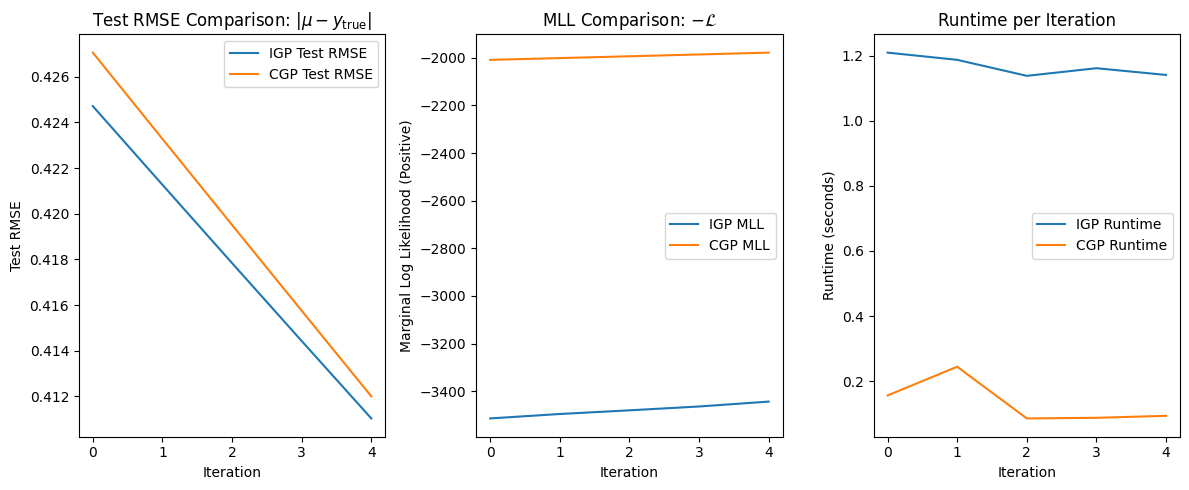

In [3]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    
    runtime_log, mll_loss_log, test_rmse_log = [], [], []
    
    for i in tqdm(range(training_iterations)):
        start_time = time.time()
        
        optimizer.zero_grad()
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        torch.autograd.set_detect_anomaly(True)
        loss.backward()
        optimizer.step()
        
        mean, covar = model.predict(test_x)
        
        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())  # Logging positive MLL value
        
        test_rmse = torch.mean(torch.abs(mean.detach().cpu()- test_y)).item()
        test_rmse_log.append(test_rmse)
        
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar

# Example usage:
# Assuming that model_igp and model_cgp are instantiated GP models (Iterative GP and Cholesky GP respectively),
# and train_x, train_y, test_x, test_y are already defined.
base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

cgp = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)


base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

igp = IterativeGaussianProcess(kernel=kernel, noise=0.4, dtype=global_dtype, device=device,
                               cg_tol=1e-2, cg_max_iter=100, warm_start=True, num_probes=16,
                               precon_type="piv_chol", trace_backend="Hutch",
                               verbose=False, track_iterations=False, 
                               pred_lanczos_rank=train_x.shape[0], compute_covariance=False)
                               
# Train the iterative GP model
model_igp, runtime_log_igp, mll_loss_log_igp, test_rmse_log_igp, mean_igp, covar_igp = train(igp, train_x, train_y, test_x, test_y, training_iterations=5, lr=0.01)

# Train the Cholesky-based GP model
model_cgp, runtime_log_cgp, mll_loss_log_cgp, test_rmse_log_cgp, mean_cgp, covar_cgp = train(cgp, train_x, train_y, test_x, test_y, training_iterations=5, lr=0.01)

# ----------------------------
# Two-Panel Plot: RMSE, MLL, and Runtime
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot RMSE comparison: |μ - yₜᵣᵤₑ|
axes[0].plot(test_rmse_log_igp, label="IGP Test RMSE")
axes[0].plot(test_rmse_log_cgp, label="CGP Test RMSE")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test RMSE")
axes[0].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[0].legend()

# Plot MLL comparison: -𝓛 (where a lower negative loss indicates a higher likelihood)
axes[1].plot(mll_loss_log_igp, label="IGP MLL")
axes[1].plot(mll_loss_log_cgp, label="CGP MLL")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Marginal Log Likelihood (Positive)")
axes[1].set_title(r"MLL Comparison: $-\mathcal{L}$")
axes[1].legend()

# Plot runtime per iteration
axes[2].plot(runtime_log_igp, label="IGP Runtime")
axes[2].plot(runtime_log_cgp, label="CGP Runtime")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Runtime (seconds)")
axes[2].set_title(r"Runtime per Iteration")
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch

def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3), 
                  n_train=40, n_test=100, noise_std=0.1, dim=1,
                  device='cuda:0', dtype=torch.float64):
    # Generate training data: each sample is a vector in R^dim
    low_train, high_train = train_range
    X_train = torch.empty((n_train, dim), dtype=dtype, device=device).uniform_(low_train, high_train)
    y_train = true_function(X_train) + noise_std * torch.randn(n_train, dtype=dtype, device=device)
    
    # Generate test data: samples drawn uniformly from the test range
    low_test, high_test = test_range
    X_test = torch.empty((n_test, dim), dtype=dtype, device=device).uniform_(low_test, high_test)
    y_test = true_function(X_test)  # No noise added to test data
    
    return X_train, y_train, X_test, y_test

# Define the true function for high-dimensional input
def true_function(x):
    # x is assumed to be of shape (n, dim).
    # For illustration, we define a function:
    #   f(x) = \sum_{i=1}^{dim} (\sin(2 x_i) + \cos(3 x_i))
    # If x has shape (n, dim), the output is (n,)
    return torch.sum(torch.sin(2 * x) + torch.cos(3 * x), dim=1)

# Set global_dtype if needed, for example:
global_dtype = torch.float64

# Generate data with dim=5 for example
train_x, train_y, test_x, test_y = generate_data(true_function,
                                                  train_range=(-3, 3),
                                                  test_range=(-5, 5),
                                                  n_train=40,
                                                  n_test=100,
                                                  noise_std=0.1,
                                                  dim=5,
                                                  dtype=global_dtype)

In [ ]:

base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1] , lengthscale_prior=GammaPrior(-3.0, 3.0),nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
model = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=.4, device='cuda:0',compute_covariance=True)
training_iterations=50

from tqdm import tqdm
import time



def train(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):

    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    runtime_log, mll_loss_log, test_rmse_log = [], [], []
    for i in tqdm(range(training_iterations)):
        start_time = time.time()
        optimizer.zero_grad()
        
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        loss.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

        # print(loss)
        mean, covar = model.predict(test_x)
        # mean = model.predict(test_x)

        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())
        
        test_rmse = (torch.mean(torch.abs(mean - test_y))).item()
        test_rmse_log.append(test_rmse)
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar
train_x, train_y, test_x, test_y = generate_data(true_function,train_range=(-3, 3), test_range=(-3,3),n_train=2000, dtype=global_dtype)

model, runtime_log, mll_loss_log, test_rmse_log, mean, covar = train(model, train_x, train_y, test_x, test_y, training_iterations,lr=.01)
std = torch.sqrt(torch.diag(covar))
# train_x, train_y, test_x, test_y = generate_data(true_function,train_range=(-3, 3), test_range=(-5,5), dtype=global_dtype,n_train=1000)
# ----------------------------
# Initialize the Iterative GP
# ----------------------------
base_kernel_igp = MaternKernel(ard_num_dims=train_x.shape[-1], 
                               lengthscale_prior=GammaPrior(-3.0, 3.0), 
                               nu=1.5)
kernel_igp = ScaleKernel(base_kernel_igp, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
igp_model = IterativeGaussianProcess(kernel=kernel_igp, noise=0.4, dtype=global_dtype, device=device,
                                     cg_tol=1e-3, cg_max_iter=20, warm_start=False, num_probes=16,
                                     precon_type="piv_chol", trace_backend="Hutch",
                                     verbose=False, track_iterations=True, 
                                     pred_lanczos_rank=train_x.shape[0],compute_covariance=False)

# ----------------------------
# Initialize the Cholesky GP
# ----------------------------
base_kernel_cgp = MaternKernel(ard_num_dims=train_x.shape[-1], 
                               lengthscale_prior=GammaPrior(-3.0, 3.0), 
                               nu=1.5)
kernel_cgp = ScaleKernel(base_kernel_cgp, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
cgp_model = CholeskyGaussianProcess(kernel=kernel_cgp, dtype=global_dtype, noise=0.4, device="cuda:0")

training_iterations = 50
lr = 0.01

print("Training Iterative Gaussian Process (IGP)")
igp_model, runtime_log_igp, mll_loss_log_igp, test_rmse_log_igp, mean_igp, covar_igp = \
    train(igp_model, train_x, train_y, test_x, test_y, training_iterations, lr)

print("\nTraining Cholesky Gaussian Process (CGP)")
cgp_model, runtime_log_cgp, mll_loss_log_cgp, test_rmse_log_cgp, mean_cgp, covar_cgp = \
    train(cgp_model, train_x, train_y, test_x, test_y, training_iterations, lr)

# ----------------------------
# Two-Panel Plot: RMSE and MLL
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot RMSE comparison
axes[0].plot(test_rmse_log_igp, label="IGP Test RMSE")
axes[0].plot(test_rmse_log_cgp, label="CGP Test RMSE")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test RMSE")
axes[0].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[0].legend()

# Plot MLL comparison
axes[1].plot(mll_loss_log_igp, label="IGP MLL")
axes[1].plot(mll_loss_log_cgp, label="CGP MLL")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Marginal Log Likelihood (Positive)")
axes[1].set_title(r"MLL Comparison: $-\mathcal{L}$")
axes[1].legend()


# Plot MLL comparison
axes[2].plot(runtime_log_igp, label="IGP MLL")
axes[2].plot(runtime_log_cgp, label="CGP MLL")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Runtime")
axes[2].set_title(r"time$")
axes[2].legend()
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# ----------------------------
# Optionally, Plot GP Predictions
# ----------------------------
# std_igp = torch.sqrt(torch.diag(covar_igp))
std_igp = 0

std_cgp = torch.sqrt(torch.diag(covar_cgp))

plot_gpr_results(
    train_x=train_x,
    train_y=train_y,
    test_x=test_x,
    test_y=test_y,
    GP_mean=mean_igp,
    std=std_igp,
    mll_loss_log=mll_loss_log_igp,
    test_rmse_log=test_rmse_log_igp,
)

plot_gpr_results(
    train_x=train_x,
    train_y=train_y,
    test_x=test_x,
    test_y=test_y,
    GP_mean=mean_cgp,
    std=std_cgp,
    mll_loss_log=mll_loss_log_cgp,
    test_rmse_log=test_rmse_log_cgp,
)

# model, runtime_log, mll_loss_log, test_rmse_log, mean = train(model, train_x, train_y, test_x, test_y, training_iterations,lr=.01)
# std=0
plot_gpr_results(
    train_x=train_x,
    train_y=train_y,
    test_x=test_x,
    test_y=test_y,
    GP_mean=mean,
    std=std,
    mll_loss_log=mll_loss_log,
    test_rmse_log=test_rmse_log
)